![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor

from xgboost import XGBRegressor

In [6]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [7]:
cat_cols = X.columns[X.columns.str.startswith('M_') == True]
for i in cat_cols:
    X[i] = X[i].astype('category').cat.codes

In [8]:
# Separación de datos en set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7031, 9) (3464, 9) (7031,) (3464,)


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [10]:
# Celda 1
def mse_split(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    left_mse = np.mean((y_l - np.mean(y_l))**2)
    right_mse = np.mean((y_r - np.mean(y_r))**2)
    return (left_mse * len(y_l) + right_mse * len(y_r)) / len(y)

def best_split(X, y, num_pct=10):

    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, mse

    # Para todas las varibles
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        for split in splits:
            mse = mse_split(X.iloc[:, j], y, split)

            if mse > best_split[2]:
                best_split = [j, split, mse]
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0],level=level, split=-1, n_samples=1, mse=mse)
        return tree

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    tree = dict(y_pred=y_pred,level=level, split=-1, n_samples=X.shape[0],mse=mse)

    # Revisar el criterio de parada
    if mse < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

def tree_predict(X, tree):

    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
    else:

        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
    return predicted

dt_model = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=5)
y_pred_tree = tree_predict(X_test, dt_model)

print(f'Para Decision Tree Regressor (manual), el MAE es: {mean_absolute_error(y_test, y_pred_tree):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_tree)):,.3f}.')

Para Decision Tree Regressor (manual), el MAE es: 2,089.021, y el RMSE es: 2,836.338.


Considerando el rango de precios en el conjunto de datos, que oscila entre 5001 y 79999, el modelo de Árbol de Decisión manual produce un Mean Absolute Error (MAE) de aproximadamente 2089 y un Root Mean Squared Error (RMSE) de alrededor de 2836.

Estos valores indican que, en promedio, las predicciones del modelo se desvían en alrededor de 2089 y 2836, respectivamente, del precio real de un automóvil. Esto sugiere que el modelo está realizando predicciones aceptables, pero aún hay margen para mejorar la precisión.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [11]:
# Celda 2
def bagging(X_train, y_train, X_test, B, seed):
    y_pred_test = np.zeros((X_test.shape[0], B))

    for i in range(B):
        np.random.seed(seed+i)
        idx = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
        reg = tree_grow(X_train.iloc[idx], y_train.iloc[idx], level=0, min_gain=0.001, max_depth=5, num_pct=5)
        y_pred_test[:, i] = tree_predict(X_test, reg)

    y_pred_test_mean = np.mean(y_pred_test, axis=1)

    return y_pred_test_mean

y_pred_test_mean = bagging(X_train, y_train, X_test, B=10, seed=42)

print(f'Para Bagging Regressor (manual), el MAE es: {mean_absolute_error(y_test, y_pred_test_mean):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_test_mean)):,.3f}.')

Para Bagging Regressor (manual), el MAE es: 1,903.467, y el RMSE es: 2,553.927.


Con un MAE de 1903, el modelo Bagging manual tiene un buen desempeño en la predicción de los precios de los automóviles en el conjunto de prueba. Este valor indica que, en promedio, las predicciones del modelo están desviadas en aproximadamente 1903 del precio real de un automóvil. Un MAE más bajo sugiere una mejor capacidad del modelo para predecir los precios con precisión.

El RMSE de 2553 proporciona una medida de la dispersión de los errores del modelo. Al ser menor que el RMSE obtenido con el modelo de Árbol de Decisión individual, indica una reducción en la dispersión de los errores, lo que sugiere que el modelo Bagging tiene una mayor precisión y consistencia en sus predicciones.



### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [12]:
# Celda 3

max_features_ = np.log(X_train.shape[1]).astype(int)

bag_reg = BaggingRegressor(n_estimators=10, random_state=0, max_features=max_features_)
bag_reg.fit(X_train, y_train)
y_pred = bag_reg.predict(X_test)

print(f'Para Bagging Regressor, el MAE es: {mean_absolute_error(y_test, y_pred):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred)):,.3f}.')

Para Bagging Regressor, el MAE es: 1,827.343, y el RMSE es: 2,354.449.


El MAE obtenido es de 1827, lo que indica que, en promedio, las predicciones del modelo se desvían en aproximadamente 1827 del precio real de un automóvil en el conjunto de prueba. Este valor es menor que el MAE obtenido con el modelo Bagging manual, lo que sugiere una mejora en la precisión de las predicciones.

El RMSE obtenido es de 2354, que proporciona una medida de la dispersión de los errores del modelo. Al igual que el MAE, el RMSE es menor que el obtenido con el modelo Bagging manual, lo que indica una reducción en la dispersión de los errores y una mejora en la precisión de las predicciones.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [13]:
# Celda 4

rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
y_pred_ = rf_reg.predict(X_test)

print(f'Para Random Forest Regressor, el MAE es: {mean_absolute_error(y_test, y_pred_):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_)):,.3f}.')

Para Random Forest Regressor, el MAE es: 1,310.185, y el RMSE es: 1,760.979.


El MAE obtenido es de 1,310.185, lo que indica que, en promedio, las predicciones del modelo se desvían en aproximadamente 1,310 del precio real de un automóvil en el conjunto de prueba. Este valor es el más bajo entre los modelos evaluados hasta ahora, lo que sugiere una precisión aún mayor en las predicciones.

El RMSE obtenido es de 1,760.979, que proporciona una medida de la dispersión de los errores del modelo. Al ser menor que el RMSE obtenido con los modelos Bagging, indica una reducción adicional en la dispersión de los errores y una mayor precisión en las predicciones.

En conclusión, el desempeño del modelo Random Forest es superior al de los modelos Bagging tanto en términos de MAE como de RMSE. Esto sugiere que el modelo Random Forest puede estar capturando de manera más efectiva las relaciones complejas entre las características y el precio de los automóviles, lo que resulta en predicciones más precisas.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

La máxima profundidad óptima es: 8 (MAE:1,150.757).
El número óptimo de atributos es: 5 (MAE:1,140.474).
El número óptimo de estimadores es: 114 (MAE:1,139.597).
Para Random Forest Regressor (calibrado), el MAE es: 1,139.597, y el RMSE es: 1,553.818.


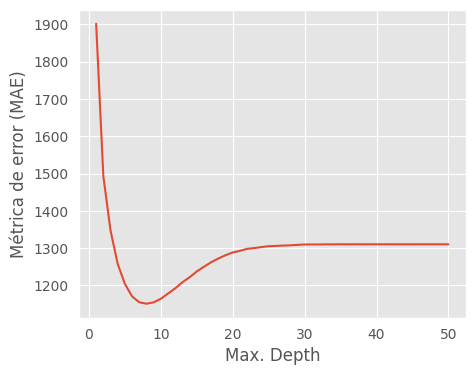

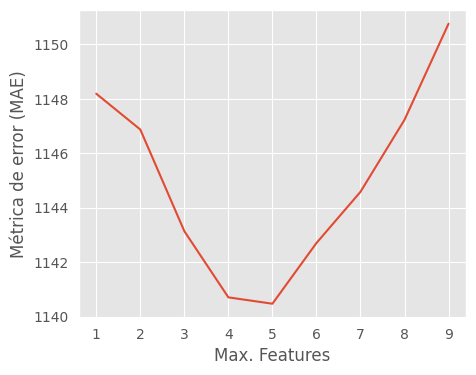

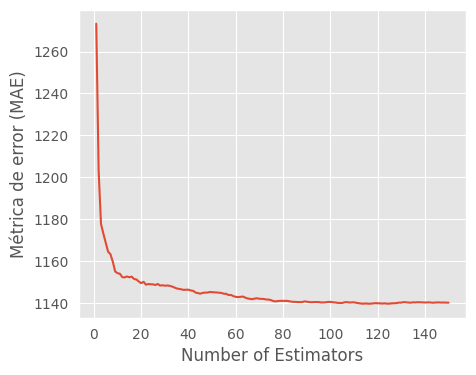

In [14]:
# Celda 5

# Calibración de hiperparámetros: Profundidad óptima del árbol (max_depth)
depth_range = range(1, 51)
mae_scores_depth= []

for depth in depth_range:
    rf_reg = RandomForestRegressor(random_state=0, max_depth=depth, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred_ = rf_reg.predict(X_test)
    mae_scores_depth.append(mean_absolute_error(y_test, y_pred_))

plt.figure(figsize=(5,4))
plt.plot(depth_range, mae_scores_depth)
plt.xlabel('Max. Depth')
plt.ylabel('Métrica de error (MAE)');

print(f'La máxima profundidad óptima es: {depth_range[np.argmin(mae_scores_depth)]} (MAE:{np.min(mae_scores_depth):,.3f}).')

# Calibración de hiperparámetros: Número óptimo de atributos del árbol (max_features)
max_features_range = range(1, X_train.shape[1]+1)
mae_scores_attr = []

for feature in max_features_range:
    rf_reg = RandomForestRegressor(random_state=0, max_features=feature, max_depth=depth_range[np.argmin(mae_scores_depth)], n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred_ = rf_reg.predict(X_test)
    mae_scores_attr.append(mean_absolute_error(y_test, y_pred_))

plt.figure(figsize=(5,4))
plt.plot(max_features_range, mae_scores_attr)
plt.xlabel('Max. Features')
plt.ylabel('Métrica de error (MAE)');

print(f'El número óptimo de atributos es: {max_features_range[np.argmin(mae_scores_attr)]} (MAE:{np.min(mae_scores_attr):,.3f}).')

# Calibración de hiperparámetros: Número óptimo de estimadores (n_estimators)

n_estimators_range = range(1, 151)
mae_scores_estim = []

for estim in n_estimators_range:
    rf_reg = RandomForestRegressor(n_estimators=estim, random_state=0, max_features=max_features_range[np.argmin(mae_scores_attr)], max_depth=depth_range[np.argmin(mae_scores_depth)], n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred_ = rf_reg.predict(X_test)
    mae_scores_estim.append(mean_absolute_error(y_test, y_pred_))

plt.figure(figsize=(5,4))
plt.plot(n_estimators_range, mae_scores_estim)
plt.xlabel('Number of Estimators')
plt.ylabel('Métrica de error (MAE)');

print(f'El número óptimo de estimadores es: {n_estimators_range[np.argmin(mae_scores_estim)]} (MAE:{np.min(mae_scores_estim):,.3f}).')

#Modelo con hiperparámetros calibrados
rf_reg_opt = RandomForestRegressor(n_estimators=n_estimators_range[np.argmin(mae_scores_estim)], random_state=0, max_features=max_features_range[np.argmin(mae_scores_attr)], max_depth=depth_range[np.argmin(mae_scores_depth)], n_jobs=-1)
rf_reg_opt.fit(X_train, y_train)
y_pred_opt = rf_reg_opt.predict(X_test)

print(f'Para Random Forest Regressor (calibrado), el MAE es: {mean_absolute_error(y_test, y_pred_opt):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_opt)):,.3f}.')

Se encontró en la Profundidad óptima del árbol (max_depth)que el valor óptimo es 8, con un error absoluto medio (MAE) mínimo de aproximadamente 1,150.757. Esto indica que una profundidad de árbol de alrededor de 8 capas es suficiente para capturar la complejidad de los datos y evitar el sobreajuste.

Se encontró también que el número óptimo de atributos seleccionados en cada división del árbol es 5, con un MAE mínimo de aproximadamente 1,140.474. Esto sugiere que al considerar solo una fracción de los atributos en cada división, el modelo puede generalizar mejor y reducir la varianza.

Se determinó que el número óptimo de estimadores (número de árboles) es 114, con un MAE mínimo de aproximadamente 1,139.597. Aumentar el número de estimadores permite que el modelo capture mejor la variabilidad de los datos, lo que conduce a una mejora en el rendimiento predictivo.

En general, estos resultados sugieren que el modelo de Random Forest calibrado es capaz de realizar predicciones precisas para el precio de los automóviles en el conjunto de datos dado, con un MAE de alrededor de 1,139.597 y un RMSE de aproximadamente 1,553.818. Esto indica un buen rendimiento del modelo en la estimación de los precios de los automóviles en función de las características proporcionadas.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [16]:
# Celda 6

xgb_reg = XGBRegressor(n_estimators=13, max_depth=5, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

print(f'Para XGBoost Regressor, el MAE es: {mean_absolute_error(y_test, y_pred_xgb):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):,.3f}.')

Para XGBoost Regressor, el MAE es: 1,138.112, y el RMSE es: 1,551.929.


El MAE obtenido es de aproximadamente 1,138.112. Esto significa que, en promedio, las predicciones del modelo tienen un error absoluto de alrededor de 1,138 en comparación con los precios reales de los automóviles. Un MAE bajo indica que el modelo tiende a cometer errores relativamente pequeños en sus predicciones.

El RMSE calculado es de aproximadamente 1,551.929. El RMSE es una medida de la dispersión de los errores en las predicciones del modelo. Un valor bajo de RMSE indica que las predicciones del modelo están generalmente cerca de los valores reales, lo que sugiere un buen ajuste del modelo a los datos.

### Punto 7 - Calibración de parámetros XGBoost



En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

La rata de aprendizaje óptima es: 0.41 (MAE:1,134.575).
El valor de gamma óptimo es: 0.0 (MAE:1,134.575).
El número de atributos óptimo por nodo es: 1.0 (MAE:1,134.575).
Para XGBoost Regressor (calibrado), el MAE es: 1,134.575, y el RMSE es: 1,547.432.


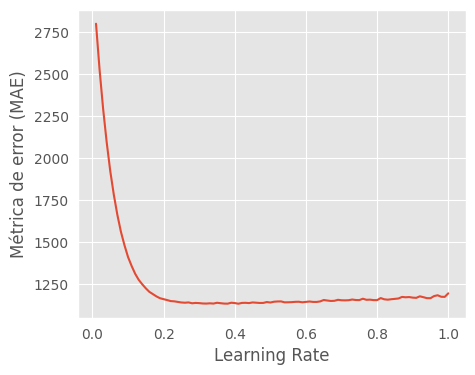

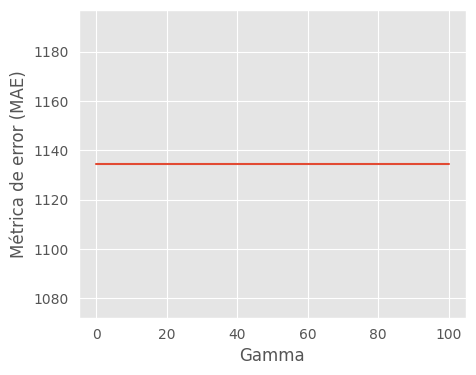

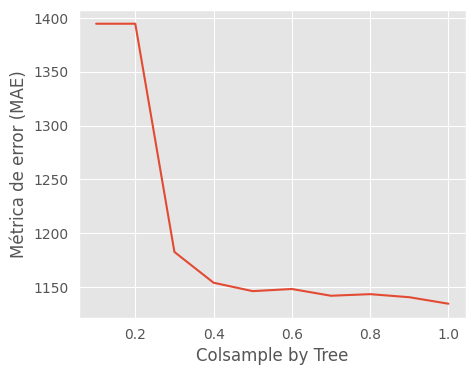

In [17]:
# Celda 7

# Calibración de hiperparámetros: Rata de aprendizaje óptima del algoritmo (learning_rate)
learning_range = [round(x,3) for x in np.linspace(0.01,1,100)]
mae_scores_learn = []

for learn in learning_range:
    xgb_reg_= XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learn,n_jobs=-1)
    xgb_reg_.fit(X_train,y_train)
    y_pred_ = xgb_reg_.predict(X_test)
    mae_scores_learn.append(mean_absolute_error(y_test, y_pred_))

print(f'La rata de aprendizaje óptima es: {learning_range[np.argmin(mae_scores_learn)]} (MAE:{np.min(mae_scores_learn):,.3f}).')

plt.figure(figsize=(5,4))
plt.plot(learning_range, mae_scores_learn)
plt.xlabel('Learning Rate')
plt.ylabel('Métrica de error (MAE)');

# Calibración de hiperparámetros: Valor de gamma óptimo del algoritmo (gamma)

gamma_range = [round(x,2) for x in np.linspace(0,100,50)]
mae_scores_gamma = []

for gamma in gamma_range:
    xgb_reg_= XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learning_range[np.argmin(mae_scores_learn)],gamma=gamma,n_jobs=-1)
    xgb_reg_.fit(X_train,y_train)
    y_pred_ = xgb_reg_.predict(X_test)
    mae_scores_gamma.append(mean_absolute_error(y_test, y_pred_))

print(f'El valor de gamma óptimo es: {gamma_range[np.argmin(mae_scores_gamma)]} (MAE:{np.min(mae_scores_gamma):,.3f}).')

plt.figure(figsize=(5,4))
plt.plot(gamma_range, mae_scores_gamma)
plt.xlabel('Gamma')
plt.ylabel('Métrica de error (MAE)');

# Calibración de hiperparámetros: Número de atributos óptimo por nodo en el árbol (colsample_bytree)

colsample_range = [x for x in np.linspace(0.1,1,10)]
mae_scores_colsample = []

for colsample in colsample_range:
    xgb_reg_= XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learning_range[np.argmin(mae_scores_learn)],gamma=gamma_range[np.argmin(mae_scores_gamma)],colsample_bytree=colsample,n_jobs=-1)
    xgb_reg_.fit(X_train,y_train)
    y_pred_ = xgb_reg_.predict(X_test)
    mae_scores_colsample.append(mean_absolute_error(y_test, y_pred_))

print(f'El número de atributos óptimo por nodo es: {colsample_range[np.argmin(mae_scores_colsample)]} (MAE:{np.min(mae_scores_colsample):,.3f}).')

plt.figure(figsize=(5,4))
plt.plot(colsample_range, mae_scores_colsample)
plt.xlabel('Colsample by Tree')
plt.ylabel('Métrica de error (MAE)');

#Modelo con hiperparámetros calibrados

xgb_reg_opt = XGBRegressor(n_estimators=13, max_depth=5,learning_rate=learning_range[np.argmin(mae_scores_learn)],gamma=gamma_range[np.argmin(mae_scores_gamma)],colsample_bytree=colsample_range[np.argmin(mae_scores_colsample)],n_jobs=-1)
xgb_reg_opt.fit(X_train, y_train)
y_pred_xgb_opt = xgb_reg_opt.predict(X_test)

print(f'Para XGBoost Regressor (calibrado), el MAE es: {mean_absolute_error(y_test, y_pred_xgb_opt):,.3f}, y el RMSE es: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt)):,.3f}.')


La rata de aprendizaje óptima encontrada es 0.41, con un MAE mínimo de aproximadamente 1,134.575. Una rata de aprendizaje más alta puede llevar a un entrenamiento más rápido, pero también puede hacer que el modelo se sobreajuste.

Se encontró que el valor óptimo de gamma es 0.0, lo que significa que no se aplicó ninguna penalización por sobreajuste en la construcción de árboles.

El número óptimo de atributos por nodo es 1.0, lo que significa que se utiliza un solo atributo por nodo en la construcción del árbol.

El modelo XGBoost calibrado con los parámetros óptimos tiene un MAE de aproximadamente 1,134.575 y un RMSE de alrededor de 1,547.432. Estos resultados muestran que el modelo XGBoost calibrado es capaz de realizar predicciones precisas para el precio de los automóviles en el conjunto de datos dado. La calibración de hiperparámetros ha mejorado el rendimiento del modelo en comparación con los valores predeterminados de los parámetros.


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

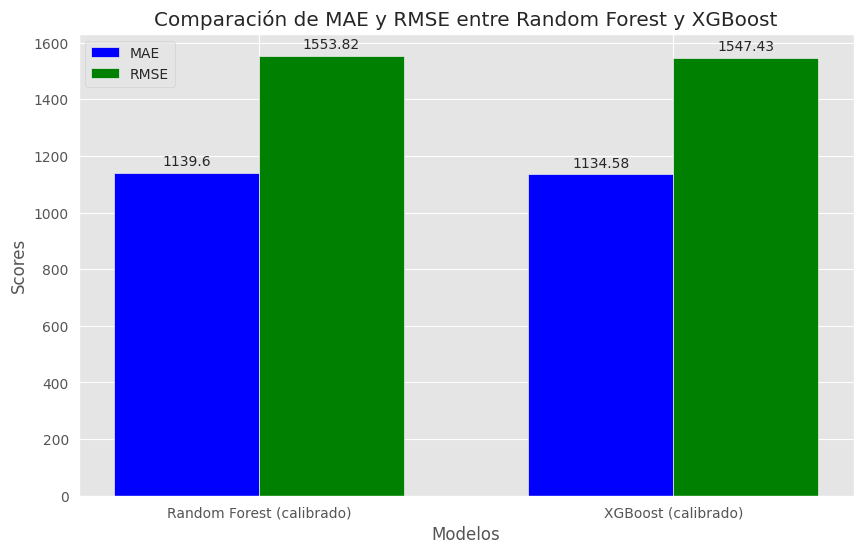

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Resultados de los modelos
models = ['Random Forest (calibrado)', 'XGBoost (calibrado)']
mae_scores = [1139.597, 1134.575]  # MAE de cada modelo
rmse_scores = [1553.818, 1547.432]  # RMSE de cada modelo

# Gráfico de barras para comparar MAE y RMSE juntos
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

bar1 = ax.bar(index, mae_scores, bar_width, label='MAE', color='blue')
bar2 = ax.bar(index + bar_width, rmse_scores, bar_width, label='RMSE', color='green')

ax.set_xlabel('Modelos')
ax.set_ylabel('Scores')
ax.set_title('Comparación de MAE y RMSE entre Random Forest y XGBoost')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Agregar etiquetas de datos
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

plt.show()


# **Resultados de los modelos:**

**Random Forest (calibrado):**
MAE: 1,139.597
RMSE: 1,553.818

**XGBoost (calibrado):**
MAE: 1,134.575
RMSE: 1,547.432

# **Análisis y comparación:**


Aunque Random Forest calibrado muestra un rendimiento cercano al de XGBoost, en este caso particular, XGBoost logra una ligera ventaja en términos de precisión.

Es importante tener en cuenta que Random Forest, aunque también es un modelo sólido, puede ser más costoso computacionalmente en conjuntos de datos grandes debido a su estructura basada en árboles y el uso de múltiples árboles de decisión. En contraste, XGBoost ofrece una eficiencia mejorada y resultados ligeramente superiores en este análisis específico.

